## within-host viral dynamics

- fit Lognormal distribution to pooled time to symptom onset since infection data from Lessler et al. (2009).
- fit Gamma distribution to time to initiation of treatment since symptom onset data in CAPSTONE trial.
- fit within-most model to viral load data in CAPSTONE trial.
- fit Lognormal distribution to placebo symptom duration data in CAPSTONE trial

## import libraries

In [1]:
import sciris as sc
import pandas as pd 
import scipy.stats as st
from scipy.optimize import minimize, least_squares
from scipy.integrate import odeint, solve_ivp
from scipy.special import expit
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, auc
import numpy as np 
from numba import jit, prange
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import gridspec
from matplotlib.lines import Line2D
import seaborn as sns 
import multiprocess as mp

## fit lognormal parameters for time to symptom onset using pooled data from Lessler et al. (2009)

In [2]:
def g(y): 
    # get percentile array based on lognormal distribution 
    mu, sigma = y
    dist = st.lognorm(s=sigma, scale=np.exp(mu))
    percentile = 1 - np.asarray([0.05, 0.25, 0.5, 0.75, 0.95])
    return dist.isf(percentile)

def cost_function(estimate_y, measured_y, method='rmse'): 
    if method == 'rmse': 
        return root_mean_squared_error(measured_y, estimate_y)
    elif method == 'mae':
        return mean_absolute_error(measured_y, estimate_y)
    else: 
        raise Exception("invalid cost funciton method.")
        
def fit_symptom_onset(y):
    # data from https://doi.org/10.1016/S1473-3099(09)70069-6
    measured_y = np.asarray([0.7, 1.1, 1.4, 1.9, 2.8]) 
    return cost_function(g(y), measured_y, method='rmse')

minfn = minimize(fit_symptom_onset, x0=[1., 1.])
f1_lnorm_mu, f1_lnorm_sigma = minfn.x
print (minfn)

print ("Time to symptom onset ~ Lognormal(mu=%.2f, sigma=%.2f)"%(f1_lnorm_mu, f1_lnorm_sigma))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.019761963867861283
        x: [ 3.519e-01  4.136e-01]
      nit: 11
      jac: [ 1.205e-06 -1.307e-06]
 hess_inv: [[ 1.329e-02 -7.443e-03]
            [-7.443e-03  8.212e-03]]
     nfev: 54
     njev: 18
Time to symptom onset ~ Lognormal(mu=0.35, sigma=0.41)


## generate discretized time to symptom onset distribution 

In [3]:
# Discretize symptom onset distribution 
dist = st.lognorm(s=f1_lnorm_sigma, scale=np.exp(f1_lnorm_mu))
discrete_time_bins = np.asarray([0.] + list(np.linspace(1.5, 28.5, 28)))

discrete_probability = [0.]
for t in range(discrete_time_bins.size): 
    if t > 0:
        discrete_probability.append(dist.cdf(discrete_time_bins[t]) - dist.cdf(discrete_time_bins[t-1]))
discrete_probability = np.asarray(discrete_probability)
discrete_probability[discrete_probability<1e-6] = 0.
discrete_probability /= discrete_probability.sum()
discrete_probability = discrete_probability[:15]
print (discrete_probability)

np.savez("../data/discr_symp_onset_dist.npz", t=np.arange(discrete_probability.size), p=discrete_probability)

[0.00000000e+00 5.51525933e-01 3.62305750e-01 7.14787798e-02
 1.20223979e-02 2.13249169e-03 4.16494812e-04 8.98747991e-05
 2.12800330e-05 5.47838908e-06 1.51989531e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


## fitting time to initiation of treatment of CAPSTONE trial to Gamma Distribution

In [4]:
def generate_treatment_init_samples(data_type='placebo'): 
    if data_type == 'placebo':
        rng = np.random.RandomState(0)
        return np.concatenate((rng.uniform(low=0, high=12, size=34), 
                               rng.uniform(low=12, high=24, size=87),
                               rng.uniform(low=24, high=36, size=67),
                               rng.uniform(low=36, high=48, size=43)))
    elif data_type == 'baloxavir': 
        rng = np.random.RandomState(1)
        return np.concatenate((rng.uniform(low=0, high=12, size=60), 
                               rng.uniform(low=12, high=24, size=178),
                               rng.uniform(low=24, high=36, size=139),
                               rng.uniform(low=36, high=48, size=79)))
    elif data_type == 'baloxavir_resistance':
        rng = np.random.RandomState(3)
        # data from https://academic.oup.com/jid/article/221/3/346/5532607
        return np.concatenate((rng.uniform(low=0, high=12, size=6), 
                               rng.uniform(low=12, high=24, size=16),
                               rng.uniform(low=24, high=36, size=9),
                               rng.uniform(low=36, high=48, size=4)))
    else: 
        rng = np.random.RandomState(2)
        return np.concatenate((rng.uniform(low=0, high=12, size=41), 
                               rng.uniform(low=12, high=24, size=163),
                               rng.uniform(low=24, high=36, size=94),
                               rng.uniform(low=36, high=48, size=79)))

def characterize_treatment_init(data_type, print_dist=1):
    samples = [generate_treatment_init_samples(data_type=data_type) for i in range(1000)]
    
    def g(y): 
        # get percentile array based on lognormal distribution 
        shape, scale = y
        mu_ll = -np.sum([st.gamma(a=shape, scale=scale).logpdf(s).sum() for s in samples])
        return mu_ll

    minfn = minimize(g, x0=[4., 6.3], method='Nelder-Mead', options={"maxiter":100})
    capstone_admin_tau_shape, capstone_admin_tau_scale = minfn.x
    
    print ("Administration of %s since symptom onset ~ Gamma(shape = %.2f, scale = %.2f)"%(data_type, capstone_admin_tau_shape, capstone_admin_tau_scale))
    
    return capstone_admin_tau_shape, capstone_admin_tau_scale

treatment_to_pars = {}
for treatment in ['placebo', 'baloxavir', 'baloxavir_resistance', 'oseltamivir']: 
    treatment_to_pars[treatment] = characterize_treatment_init(treatment)
print (treatment_to_pars)

Administration of placebo since symptom onset ~ Gamma(shape = 2.91, scale = 8.31)
Administration of baloxavir since symptom onset ~ Gamma(shape = 2.40, scale = 10.12)
Administration of baloxavir_resistance since symptom onset ~ Gamma(shape = 3.32, scale = 6.52)
Administration of oseltamivir since symptom onset ~ Gamma(shape = 2.87, scale = 8.53)
{'placebo': (2.9112099911602103, 8.31346456572097), 'baloxavir': (2.4038599641663456, 10.12014461414038), 'baloxavir_resistance': (3.3228091893974128, 6.51500164560059), 'oseltamivir': (2.8735909112157914, 8.528978488863046)}


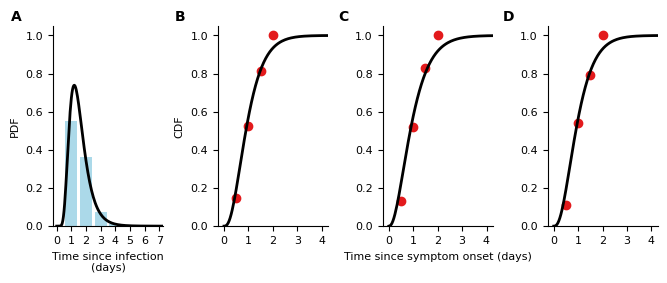

In [5]:
def ax_cosmetics(ax):
    for axis in ['top', 'right']: 
        ax.spines[axis].set_visible(False)
    ax.tick_params(axis='both', labelsize=8)
    
fig = plt.figure(figsize=(7.8, 10.4 * 0.25))
gs = gridspec.GridSpec(nrows=1, ncols=4, wspace=0.5)

def plot_admin_treatment(ax, treatment): 
    ax.plot(np.arange(0, 8*24)/24, 
        st.gamma.cdf(np.arange(0, 8*24), a=treatment_to_pars[treatment][0], scale=treatment_to_pars[treatment][1]),
        lw=2., c='k')
    ax.set_xticks(range(8))
    ax.set_ylim(-0.0, 1.05)
    ax.set_xlim(-0.25, 4.25)
    sample_t = generate_treatment_init_samples(treatment)
    admin_t_lim = np.asarray([0.5, 1., 1.5, 2.])
    ax.scatter(admin_t_lim, [sample_t[sample_t <= t*24].size/sample_t.size for _t, t in enumerate(admin_t_lim)], c = '#e31a1c')
    ax_cosmetics(ax)

## symptom onset ## 
ax = fig.add_subplot(gs[0])
dist = st.lognorm(s=f1_lnorm_sigma, scale=np.exp(f1_lnorm_mu))
discrete_probability = np.load("../data/discr_symp_onset_dist.npz")["p"]
ax.bar(range(discrete_probability.size), discrete_probability, fc='#abd9e9')
cont_X = np.arange(0, discrete_probability.size*24)/24
ax.plot(cont_X, dist.pdf(cont_X), c='k', lw=2.)
ax_cosmetics(ax)
ax.set_ylabel("PDF", fontsize=8)
ax.set_xlabel("Time since infection\n(days)", fontsize=8)
ax.set_xlim(-0.25, 7.25)
ax.set_xticks(range(8))
ax.set_ylim(-0.0, 1.05)

## administration of treatment 
ax1, ax2, ax3 = fig.add_subplot(gs[1]), fig.add_subplot(gs[2]), fig.add_subplot(gs[3])
plot_admin_treatment(ax1, "placebo")
plot_admin_treatment(ax2, "baloxavir")
plot_admin_treatment(ax3, "oseltamivir")
ax1.set_ylabel("CDF", fontsize=8)
ax2.set_xlabel("Time since symptom onset (days)", fontsize=8)

for f, label in enumerate(["a", "b", "c", "d"]):
    fig.text(x=(f * 0.21)+0.07, y=0.9, s=r"$\bf{%s}$"%(label.capitalize()))

plt.savefig("../manuscript/lancetID_fig_s01.png", dpi=600, bbox_inches='tight')
plt.show()

## generate viral load data

placebo


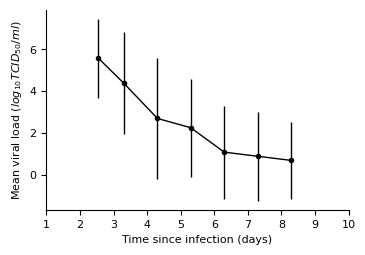

(210, 8)
[[5.56       4.37967213 2.69114754 2.24852459 1.08459016 0.88786885
  0.69114754]
 [1.89       2.42622951 2.86885246 2.3442623  2.21311475 2.1147541
  1.85245902]]
baloxavir


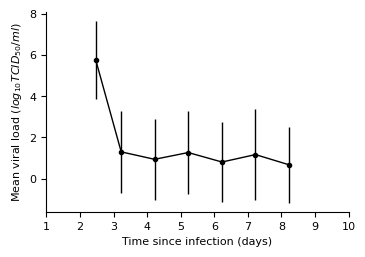

(427, 8)
[[5.76       1.30098361 0.94032787 1.26819672 0.80918033 1.16983607
  0.67803279]
 [1.9        2.         1.96721311 2.01639344 1.91803279 2.19672131
  1.83606557]]
baloxavir_resistance


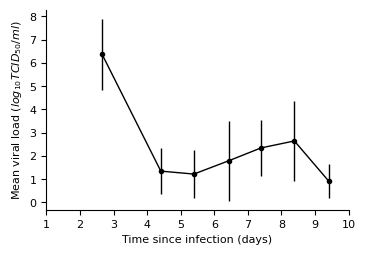

(35, 8)
[[6.36677353 1.3479228  1.22093759 1.79890202 2.34482373 2.64507484
  0.90764392]
 [1.53805073 0.99333415 1.04673869 1.71962617 1.18557106 1.70893554
  0.72629202]]
oseltamivir


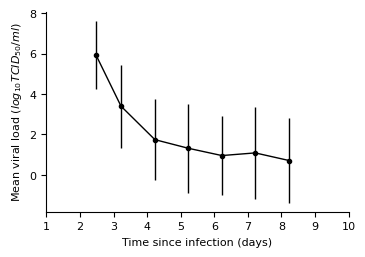

(377, 8)
[[5.94       3.39901639 1.74327869 1.31704918 0.95639344 1.08754098
  0.7104918 ]
 [1.69       2.04918033 2.01639344 2.19672131 1.96721311 2.27868852
  2.08196721]]


In [6]:
def generate_vl_traj(data_type, capstone_admin_tau_shape, capstone_admin_tau_scale, f1_lnorm_mu, f1_lnorm_sigma):
    
    if data_type == 'oseltamivir_resistance':
        # Lina et al. oseltamivir resistance viral load data 
        resist_vl_data = pd.read_excel("../data/lina-et-al-2018_oseltamivir_resist_vl_dat.xlsx")
        t_dat = np.asarray([0, 3, 6, 10]) # time in days 
        viral_load_data = resist_vl_data[["VL%02i"%(t) for t in t_dat]].to_numpy()

        vl_norm_pars = np.zeros((2, t_dat.size))
        vl_norm_pars[0] = viral_load_data.mean(axis=0)
        vl_norm_pars[1] = viral_load_data.std(axis=0, ddof=1)
        
        data_n = viral_load_data.shape[0]
        data_t = np.zeros((data_n, t_dat.size+1), dtype=np.float32)
        # randomly generate symptom onset time 
        rng = np.random.RandomState(0)
        data_t[:,0] = st.lognorm.rvs(size=data_n, s=f1_lnorm_sigma, scale=np.exp(f1_lnorm_mu), random_state=rng) * 24
        # randomly generate time of antiviral administration 
        tau = st.gamma.rvs(size=data_n, a=capstone_admin_tau_shape, scale=capstone_admin_tau_scale, random_state=rng)
        tau[tau>48] = 48. 
        data_t[:,1] = data_t[:,0] + tau
        data_t = data_t - 0.5
        
        # generate time points when viral loads were sampled and viral load themselves 
        for tidx in range(1, t_dat.size): 
            d = t_dat[tidx]+1
            print (tidx, d)
            t_upper_lim = d*24
            t_lower_lim = t_upper_lim-24
            # timepoints 
            data_t[:,tidx+1] = data_t[:,1] + np.random.uniform(low=t_lower_lim, high=t_upper_lim, size=data_n)

        # make time to per day basis 
        data_t /= 24

        with plt.style.context("default"): 
            fig, ax = plt.subplots(1, 1, figsize=(7.8 * 0.5, 10.4 * 0.25))
    
            X = data_t[:,1:].mean(axis=0)
            #print (X)
            #ax.plot(X, data_vl.mean(axis=0), c='k', lw=1.)
            #ax.errorbar(X, data_vl.mean(axis=0), yerr=data_vl.std(axis=0), marker="+", c='k', lw=1.)
            ax.errorbar(X, vl_norm_pars[0], yerr=vl_norm_pars[1], marker=".", c = 'k', lw=1.)
            
            #ax.axvline(data_t[:,0].mean(), lw=1., ls='--', c='k')
            #ax.text(x=data_t[:,0].mean(), y=ax.get_ylim()[-1], s='Average symptom onset time', rotation=90, ha='right', va='top', fontsize=6)
            
            # plot oseltamivir no resist 
            noresist_X = treatment_to_data['oseltamivir']['data_t'][:,1:].mean(axis=0)
            noresist_vl_norm_pars = treatment_to_data['oseltamivir']['vl_norm_pars']
            ax.errorbar(noresist_X, noresist_vl_norm_pars[0], yerr=noresist_vl_norm_pars[1], marker=".", c = 'r', lw=1.)

            mutant_vl_norm_pars = np.zeros((2, t_dat.size), dtype=np.float32) + 0.5
            for tidx in range(1, t_dat.size):
                if tidx == t_dat.size - 1: 
                    mutant_mu_resist, mutant_std_resist = vl_norm_pars[0,tidx], vl_norm_pars[1,tidx]
                    
                else: 
                    mu_resist, std_resist = vl_norm_pars[0,tidx], vl_norm_pars[1,tidx]
                    mu_noresist, std_resist = noresist_vl_norm_pars[0,int(tidx*3)], noresist_vl_norm_pars[1,int(tidx*3)]
                    
                    mutant_mu_resist = mu_resist - mu_noresist
                    mutant_std_resist = np.sqrt(std_resist**2 + std_resist**2)

                mutant_vl_norm_pars[:,tidx] = [mutant_mu_resist, mutant_std_resist]

            ax.errorbar(X, mutant_vl_norm_pars[0], yerr=mutant_vl_norm_pars[1], marker=".", c = 'b', lw=1.)
            
            ax_cosmetics(ax)
            ax.set_ylabel("Mean viral load ($log_{10} TCID_{50}/ml$)", fontsize=8)
            ax.set_xlabel("Time since infection (days)", fontsize=8)
            ax.set_xlim(1, 10)
            plt.show()

        # return expected mutant viral load 
        return data_t, mutant_vl_norm_pars
        
    elif data_type == 'baloxavir_resistance': 
        # Uehara et al. baloxavir resistance viral load data 
        resist_vl_data = pd.read_csv("../data/uehara-et-al_jid_baloxavir_resist_viral_load.csv")
        
        # load viral load data 
        vl_norm_pars = np.zeros((2, len(resist_vl_data)))
        vl_norm_pars[0] = resist_vl_data['mean'].to_numpy()
        vl_norm_pars[1] = resist_vl_data['sd'].to_numpy()
        
        data_n = 35
        data_t = np.zeros((data_n, len(resist_vl_data)+1), dtype=np.float32)
        # randomly generate symptom onset time 
        rng = np.random.RandomState(0)
        data_t[:,0] = st.lognorm.rvs(size=data_n, s=f1_lnorm_sigma, scale=np.exp(f1_lnorm_mu), random_state=rng) * 24
        # randomly generate time of antiviral administration 
        tau = st.gamma.rvs(size=data_n, a=capstone_admin_tau_shape, scale=capstone_admin_tau_scale, random_state=rng)
        tau[tau>48] = 48. 
        data_t[:,1] = data_t[:,0] + tau
        data_t = data_t - 0.5
        
        # generate timepoints when viral loads were sampled and viral load themselves 
        for d in range(1, len(resist_vl_data), 1): 
            t_upper_lim = (d+1)*24
            t_lower_lim = t_upper_lim-12
            # timepoints 
            data_t[:,d+1] = data_t[:,1] + np.random.uniform(low=t_lower_lim, high=t_upper_lim, size=data_n)
            
        # make time to per day basis 
        data_t /= 24

        with plt.style.context("default"): 
            fig, ax = plt.subplots(1, 1, figsize=(7.8 * 0.5, 10.4 * 0.25))
    
            X = data_t[:,1:].mean(axis=0)
            #print (X)
            #ax.plot(X, data_vl.mean(axis=0), c='k', lw=1.)
            #ax.errorbar(X, data_vl.mean(axis=0), yerr=data_vl.std(axis=0), marker="+", c='k', lw=1.)
            ax.errorbar(X, vl_norm_pars[0], yerr=vl_norm_pars[1], marker=".", c = 'k', lw=1.)
            
            #ax.axvline(data_t[:,0].mean(), lw=1., ls='--', c='k')
            #ax.text(x=data_t[:,0].mean(), y=ax.get_ylim()[-1], s='Average symptom onset time', rotation=90, ha='right', va='top', fontsize=6)
            ax_cosmetics(ax)
            ax.set_ylabel("Mean viral load ($log_{10} TCID_{50}/ml$)", fontsize=8)
            ax.set_xlabel("Time since infection (days)", fontsize=8)
            ax.set_xlim(1, 10)
            plt.show()

        return data_t, vl_norm_pars
        
    else: 
        if data_type == 'placebo':
            d0_mean, d0_std = 5.56, 1.89 # log10 TCID50/ml before initiation of placebo
            data_n = 210
        elif data_type == 'baloxavir':
            d0_mean, d0_std = 5.76, 1.90
            data_n = 427
        else:
            d0_mean, d0_std = 5.94, 1.69
            data_n = 377
            
        # data from Hayden et al. 
        vt_change_data = pd.read_excel("../data/change_in_virus_titers_data.xlsx")
        vt_change_data = vt_change_data[vt_change_data['participant']=='normal']
    
        untreated_vt_change = vt_change_data[vt_change_data['treatment']==data_type]
        mean_change_vl = untreated_vt_change['mean'].to_numpy()[1:]
        std_change_vl = untreated_vt_change['sd'].to_numpy()[1:]
    
        # generate simulated viral load data
        rng = np.random.RandomState(0)
        
        data_t = np.zeros((data_n, 2 + mean_change_vl.size), dtype=np.float32)
        vl_norm_pars = np.zeros((2, 1 + mean_change_vl.size))
        
        # randomly generate symptom onset time 
        data_t[:,0] = st.lognorm.rvs(size=data_n, s=f1_lnorm_sigma, scale=np.exp(f1_lnorm_mu), random_state=rng) * 24
        
        # randomly generate time of antiviral administration 
        tau = st.gamma.rvs(size=data_n, a=capstone_admin_tau_shape, scale=capstone_admin_tau_scale, random_state=rng)
        tau[tau>48] = 48. 
        data_t[:,1] = data_t[:,0] + tau
        
        # generate timepoints when viral loads were sampled and viral load themselves 
        for d in range(mean_change_vl.size): 
            t_upper_lim = (d+1)*24
            t_lower_lim = t_upper_lim-12
            # timepoints 
            data_t[:,1+(d+1)] = data_t[:,1] + np.random.uniform(low=t_lower_lim, high=t_upper_lim, size=data_n)
            
        # make time to per day basis 
        data_t /= 24

        with plt.style.context("default"): 
            fig, ax = plt.subplots(1, 1, figsize=(7.8 * 0.5, 10.4 * 0.25))
    
            X = data_t[:,1:].mean(axis=0)
            #print (X)
            #ax.plot(X, data_vl.mean(axis=0), c='k', lw=1.)
            #ax.errorbar(X, data_vl.mean(axis=0), yerr=data_vl.std(axis=0), marker="+", c='k', lw=1.)
            ax.errorbar(X, [d0_mean] + list(d0_mean + mean_change_vl), yerr=[d0_std] + list(std_change_vl), marker=".", c = 'k', lw=1.)
            vl_norm_pars[0,:] = [d0_mean] + list(d0_mean + mean_change_vl)
            vl_norm_pars[1,:] = [d0_std] + list(std_change_vl)
            
            #ax.axvline(data_t[:,0].mean(), lw=1., ls='--', c='k')
            #ax.text(x=data_t[:,0].mean(), y=ax.get_ylim()[-1], s='Average symptom onset time', rotation=90, ha='right', va='top', fontsize=6)
            ax_cosmetics(ax)
            ax.set_ylabel("Mean viral load ($log_{10} TCID_{50}/ml$)", fontsize=8)
            ax.set_xlabel("Time since infection (days)", fontsize=8)
            ax.set_xlim(1, 10)
            plt.show()
        
        return data_t, vl_norm_pars

treatment_to_data = {}
for treatment in ['placebo', 'baloxavir', 'baloxavir_resistance', 'oseltamivir']: 
    print (treatment)
    if treatment == 'oseltamivir_resistance':
        shape, scale = treatment_to_pars['oseltamivir']
    else: 
        shape, scale = treatment_to_pars[treatment]
    data_t, vl_norm_pars = generate_vl_traj(treatment, shape, scale, f1_lnorm_mu, f1_lnorm_sigma)
    treatment_to_data[treatment] = {"data_t":data_t, "vl_norm_pars":vl_norm_pars}
    print (data_t.shape)
    print (vl_norm_pars)

## within-host model fit

In [7]:
def plot_wh_traj(within_host_model_pars, save_plot=0, save_pars=0, no_res=0, fig_fpath="../manuscript/20240729_within_host_fit.pdf"):
    ## -- plot -- ## 
    fig = plt.figure(figsize=(7.8, 10.4 * 0.25))
    gs = gridspec.GridSpec(nrows=1, ncols=4, wspace=0.1)
    
    #bw, bm, l, r, d, k, q, a, pw, cw, pmb, cmb, pmo, cmo, Vw0, mub, eb, muo, eo = within_host_model_pars 
    bw, bm, l, r, d, k, q, a, pw, cw, pmb, cmb, Vw0, mub, eb, eo = within_host_model_pars 
    rate_pars = np.asarray([bw, bm, l, r, d, k, q, a, pw, cw])
    T0 = 4e8 

    plot_title = ["Placebo", "Baloxavir marboxil", "Oseltamivir", "Baloxavir marboxil\n(w/ treatment-emergent\nresistant mutant)"]
    
    treatment_t = []
    for axi, treatment in enumerate(['placebo', 'baloxavir', 'oseltamivir', 'baloxavir_resistance']): # oseltamivir_resistance
        if no_res > 0 and treatment == "baloxavir_resistance": 
            continue 
        ax = fig.add_subplot(gs[axi])
        
        # get tspan 
        tspan = np.linspace(0., 14., (14*24)+1)
        t_eval = treatment_to_data[treatment]['data_t'].mean(axis=0)[1:] # first time point = treatment 
        tspan = np.unique(np.concatenate((tspan, t_eval)))
        # get fitting data 
        y_true_pars = treatment_to_data[treatment]['vl_norm_pars']
    
        if treatment == 'placebo': 
            # fit placebo data - mu = e = 0
            y0_init = np.asarray([T0, 0., 0., 0., 0., Vw0, 0.])
            s0 = solve_model(rate_pars, pm=0., cm=0., mu=0., e=0., tspan=tspan, y_init=y0_init)
            # fit wild-type vl to placebo viral load data 
            Vw = s0[:,-2]
            Vw[Vw < 5.] = 5.
            V = np.log10(Vw)
    
            ax.plot(tspan, V, lw=2., c='#2b83ba', alpha=0.8)
            placebo_auc = auc(tspan, V)
    
        elif treatment == 'baloxavir' or treatment == 'oseltamivir':
            # two phase (pre-treatment and post-treatment)
            # pre-treatment 
            t0 = tspan[tspan < t_eval[0]] 
            treatment_t.append(t_eval[0])
            y0_init = np.asarray([T0, 0., 0., 0., 0., Vw0, 0.])
            s0 = solve_model(rate_pars, pm=0., cm=0., mu=0., e=0., tspan=t0, y_init=y0_init)
            # post-treatment 
            t1 = tspan[tspan >= t_eval[0]] 
            y1_init = s0[-1,:]
            print (treatment, y1_init)
            s1 = solve_model(rate_pars, pm=0., cm=0., mu=0., e=eb if treatment == 'baloxavir' else eo, tspan=t1, y_init=y1_init)
            print (s1[0,:])
            # fit viral load to baloxavir treated data 
            s0_Vw = s0[:,-2]
            s1_Vw = s1[:,-2]
            s0_Vw[s0_Vw < 5.] = 5. 
            s1_Vw[s1_Vw < 5.] = 5. 
            V = np.log10(np.concatenate((s0_Vw, s1_Vw)))
    
            ax.plot(tspan, V, lw=2., c='#2b83ba', alpha=0.8)
            treatment_auc = auc(tspan, V)
            print (treatment, 1. - treatment_auc/placebo_auc)
    
        elif treatment == 'baloxavir_resistance':  
            # three phases
            # pre-treatment + no mutation
            t0 = tspan[tspan < t_eval[0]]
            y0_init = np.asarray([T0, 0., 0., 0., 0., Vw0, 0.])
            s0 = solve_model(rate_pars, pm=0., cm=0., mu=0., e=0., tspan=t0, y_init=y0_init)
            # post-treatment + mutation
            t1 = tspan[tspan >= t_eval[0]]
            y1_init = s0[-1,:]
            s1 = solve_model(rate_pars, pm=pmb, cm=cmb, mu=mub, e=eb, tspan=t1, y_init=y1_init)
            # fit viral load to baloxavir treated data 
            Vw = np.concatenate((s0[:,-2], s1[:,-2]))
            Vm = np.concatenate((s0[:,-1], s1[:,-1]))
            V = Vw + Vm
            V[V < 5.] = 5.
            V = np.log10(V)
    
            Vw[Vw < 5.] = 5.
            Vm[Vm < 5.] = 5.
            Vw = np.log10(Vw)
            Vm = np.log10(Vm)
            
            ax.plot(tspan, Vw, lw=2., ls='-', c='#2b83ba', alpha=0.8)
            ax.plot(tspan, Vm, lw=3., ls='--', c='#d7191c', alpha=1.)
    
        elif treatment == 'oseltamivir_resistance':  
            # three phases
            # pre-treatment + no mutation
            t0 = tspan[tspan < t_eval[0]]
            y0_init = np.asarray([T0, 0., 0., 0., 0., Vw0, 0.])
            s0 = solve_model(rate_pars, pm=0., cm=0., mu=0., e=0., tspan=t0, y_init=y0_init)
            # post-treatment + mutation
            t1 = tspan[tspan >= t_eval[0]]
            y1_init = s0[-1,:]
            s1 = solve_model(rate_pars, pm=pmo, cm=cmo, mu=muo, e=eo, tspan=t1, y_init=y1_init)
            # fit viral load to baloxavir treated data 
            Vw = np.concatenate((s0[:,-2], s1[:,-2]))
            Vm = np.concatenate((s0[:,-1], s1[:,-1]))
            
            Vw[Vw < 5.] = 5.
            Vm[Vm < 5.] = 5.
            Vw = np.log10(Vw)
            Vm = np.log10(Vm)
            
            ax.plot(tspan, Vw, lw=2., ls='-', c='#2b83ba', alpha=0.8)
            ax.plot(tspan, Vm, lw=3., ls='--', c='#d7191c', alpha=1.)

        #t_eval = treatment_to_data[treatment]['data_t'].mean(axis=0)[1:] # first time point = treatment 
        tX = t_eval-0.5 if treatment == 'baloxavir_resistance' else t_eval
        #y_true_pars = treatment_to_data[treatment]['vl_norm_pars']
        ax.scatter(tX, y_true_pars[0], c='#636363', s=20, zorder=100)
        #ax.errorbar(tX, y_true_pars[0], yerr=y_true_pars[1], marker=".", c = 'r', lw=1.)
    
        ax.set_ylim(0., 7.)
        ax.set_xticks(np.arange(0, 15, 2))
        ax.set_xlim(-0.5, 14.5)
        for axis in ['top', 'right']: 
            ax.spines[axis].set_visible(False)
        if axi == 0: 
            ax.set_ylabel('Infectious viral load (TCID50/ml)', fontsize=8)
        else: 
            ax.set_yticklabels([])
            
        ax.set_title(plot_title[axi], fontsize=8)
        ax.tick_params(labelsize=8)

    if no_res > 0: 
        legend_handles = [Line2D([0], [0], marker='o', color="#636363", 
                                 label="Data", markerfacecolor="#636363", lw=0., markersize=7),
                         Line2D([0], [0], marker=None, color="#2b83ba", 
                                 label="Drug-sensitive wild-type virus", markerfacecolor="#2b83ba", lw=2., markersize=7)]
    else:  
        legend_handles = [Line2D([0], [0], marker='o', color="#636363", 
                                 label="Data", markerfacecolor="#636363", lw=0., markersize=7),
                         Line2D([0], [0], marker=None, color="#2b83ba", 
                                 label="Drug-sensitive wild-type virus", markerfacecolor="#2b83ba", lw=2., markersize=7),
                         Line2D([0], [0], marker=None, color="#d7191c", ls='--',
                                 label="Resistant mutant virus", markerfacecolor="#8073ac", lw=2., markersize=7),]
    if no_res > 0:
        fig.legend(handles=legend_handles, ncols=3, loc="lower center", bbox_to_anchor=(0.85/2, 1.), fontsize=8)
        fig.text(x = 0.85/2, y = -0.05, s="Time since infection (days)", ha='center', va='bottom', fontsize=8)
    else: 
        fig.legend(handles=legend_handles, ncols=3, loc="lower center", bbox_to_anchor=(0.5, 1.05), fontsize=8)
        fig.text(x = 0.5, y = -0.05, s="Time since infection (days)", ha='center', va='bottom', fontsize=8)

    if save_plot > 0:
        plt.savefig(fig_fpath, dpi=600, bbox_inches='tight')
    plt.show()

    treatment_t = np.asarray(treatment_t)
    if save_pars > 0:
        np.savez("../data/within_host_pars.npz", within_host_model_pars=within_host_model_pars, treatment_t=treatment_t)

baloxavir [1.05198358e+06 1.21606802e+06 3.98896875e+07 0.00000000e+00
 1.37077491e-01 3.81972989e+05 0.00000000e+00]
[1.05198358e+06 1.21606802e+06 3.98896875e+07 0.00000000e+00
 1.37077491e-01 3.81972989e+05 0.00000000e+00]
baloxavir 0.28028043106534595
oseltamivir [1.05198358e+06 1.21606802e+06 3.98896875e+07 0.00000000e+00
 1.37077491e-01 3.81972989e+05 0.00000000e+00]
[1.05198358e+06 1.21606802e+06 3.98896875e+07 0.00000000e+00
 1.37077491e-01 3.81972989e+05 0.00000000e+00]
oseltamivir 0.14362931366920106


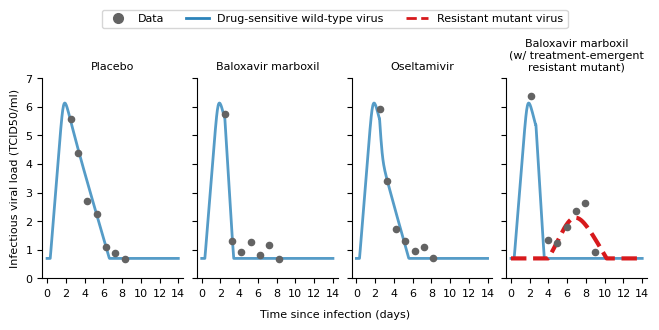

In [8]:
def within_host_model(y, t, pars): 
    # T = target cells, R = refractory cells, I = infected cells, 
    # F = interferon response, V = concentration of free infectious virions measured via TCID50 infectivity assay  
    T, R, Iw, Im, F, Vw, Vm = y
    # b = beta infection rate, l = IFN-induced antiviral efficacy 
    # r = reversion rate from refractory, d = death rate of infected cells 
    # k = killing rate of infected cells by NK cells, q = production rate of IFN 
    # a = decay rate of IFN, pw = wild-type virus replication rate, pm = mutant virus replication rate 
    # c = virus clearance rate, mu = mutation rate, e = treatment effectiveness rate 
    bw, bm, l, r, d, k, q, a, pw, pm, cw, cm, mu, e = pars 
    
    dT = -(bw * T * Vw) - (bm * T * Vm) - (l * T * F) + (r * R)
    dR = (l * T * F) - (r * R)
    dIw = (bw * T * Vw) - (d * Iw) - (k * Iw * F)
    dIm = (bm * T * Vm) - (d * Im) - (k * Im * F)
    dF = (q * (Iw + Im)) - (a * F)
    dVw = ((1 - mu) * (1 - e) * pw * Iw) - (cw * Vw)
    dVm = (pm * Im) + (mu * pw * Iw) - (cm * Vm)
    
    return [dT, dR, dIw, dIm, dF, dVw, dVm]

def solve_model(rate_pars, pm, cm, mu, e, tspan, y_init): 
    bw, bm, l, r, d, k, q, a, pw, cw = rate_pars 
    pars = np.asarray([bw, bm, l, r, d, k, q, a, pw, pm, cw, cm, mu, e])
    sol = odeint(func=within_host_model, y0=y_init, t=tspan, args=(pars,))
    return sol

def compute_norm_ll(y_pred, y_true_pars): 
    mu_ll = -np.sum([st.norm(loc=y_true_pars[0,i], scale=y_true_pars[1,i]).logpdf(yp).sum() for i, yp in enumerate(y_pred)])
    if np.isnan(mu_ll): 
        return np.inf
    else: 
        return mu_ll

def de(min_bound, max_bound, popsize, its): 
    mut = 0.3
    crossp = 0.8
    dim = min_bound.size 
    diff = max_bound - min_bound # difference between bounds 
    idx = np.arange(popsize) # index 
    # generate population (normalized)
    population = np.random.rand(popsize, dim)
    # de-normalize population 
    population_denorm = min_bound + population * diff
    # compute fitness 
    fitness = np.asarray([fobj(state=population_denorm[i,:]) for i in range(popsize)])
    best_fitness = fitness.min()
    best_idx = fitness.argmin()
    
    #print (fitness.mean(), best_fitness)
    for i in range(its): 
        if i == 0 or ((i+1)%(its/100) == 0 and fitness.min() < best_fitness):
            best_fitness = fitness.min()
            print (i+1, list(min_bound + population[best_idx] * diff), np.mean(fitness), fitness.min())

            plot_wh_traj(min_bound + population[best_idx] * diff)
            
        for j in range(popsize): 
            # randomly choose three indices without replacement excluding j 
            a, b, c = population[np.random.choice(idx[idx != j], 3, replace=False)]
            # generate mutant 
            mutant = np.clip(a + mut * (b - c), 0, 1)
            cross_points = np.random.rand(dim) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dim)] = True
            # get trial candidate 
            trial = np.where(cross_points, mutant, population[j])
            trial_denorm = min_bound + trial * diff
            trial_f = fobj(state=trial_denorm)
            # selection 
            if trial_f < fitness[j]: 
                fitness[j] = trial_f
                population[j] = trial
                
        best_idx = fitness.argmin()

    print ("best:", min_bound + population[best_idx] * diff, fitness.min(), fitness.mean())
    return min_bound + population[best_idx] * diff

def fobj(state, T0=4e8): # state
    
    #bw, bm, l, r, d, k, q, a, pw, cw, pmb, cmb, pmo, cmo, Vw0, mub, eb, muo, eo = state
    bw, bm, l, r, d, k, q, a, pw, cw, pmb, cmb, Vw0, mub, eb, eo = state
    rate_pars = np.asarray([bw, bm, l, r, d, k, q, a, pw, cw])

    ll = 0 # total log likelihood 
    for treatment in ['placebo', 'baloxavir', 'oseltamivir', 'baloxavir_resistance']: # oseltamivir_resistance
        # get tspan 
        tspan = np.linspace(0., 11., (11*24)+1)
        t_eval = treatment_to_data[treatment]['data_t'].mean(axis=0)[1:] # first time point = treatment 
        tspan = np.unique(np.concatenate((tspan, t_eval)))
        
        # get fitting data 
        y_true_pars = treatment_to_data[treatment]['vl_norm_pars']
        if treatment == 'baloxavir_resistance':
            y_Vw_true_pars = treatment_to_data['baloxavir']['vl_norm_pars']
        elif treatment == 'oseltamivir_resistance': 
            y_Vw_true_pars = treatment_to_data['oseltamivir']['vl_norm_pars']

        if treatment == 'placebo': 
            # fit placebo data - mu = e = 0
            y0_init = np.asarray([T0, 0., 0., 0., 0., Vw0, 0.])
            s0 = solve_model(rate_pars, pm=0., cm=0.,  mu=0., e=0., tspan=tspan, y_init=y0_init)
            # fit wild-type vl to placebo viral load data 
            Vw = s0[:,-2]
            Vw[Vw < 5.] = 5.
            Vw = np.log10(Vw)
            # compute log-likelihood 
            ll += compute_norm_ll(Vw[np.isin(tspan, t_eval)], y_true_pars)

        elif treatment == 'baloxavir' or treatment == 'oseltamivir':
            # two phase (pre-treatment and post-treatment)
            # pre-treatment 
            t0 = tspan[tspan < t_eval[0]] 
            y0_init = np.asarray([T0, 0., 0., 0., 0., Vw0, 0.])
            s0 = solve_model(rate_pars, pm=0., cm=0., mu=0., e=0., tspan=t0, y_init=y0_init)
            # post-treatment 
            t1 = tspan[tspan >= t_eval[0]] 
            y1_init = s0[-1,:]
            s1 = solve_model(rate_pars, pm=0., cm=0., mu=0., e=eb if treatment == 'baloxavir' else eo, tspan=t1, y_init=y1_init)
            # fit viral load to baloxavir treated data 
            s1_Vw = s1[:,-2]
            s1_Vw[s1_Vw < 5.] = 5. 
            s1_Vw = np.log10(s1_Vw)
            ll += compute_norm_ll(s1_Vw[np.isin(t1, t_eval)], y_true_pars)

        elif treatment == 'baloxavir_resistance':  
            # three phases
            # pre-treatment + no mutation
            t0 = tspan[tspan < t_eval[0]]
            y0_init = np.asarray([T0, 0., 0., 0., 0., Vw0, 0.])
            s0 = solve_model(rate_pars, pm=0., cm=0., mu=0., e=0., tspan=t0, y_init=y0_init)
            # post-treatment + mutation
            t1 = tspan[tspan >= t_eval[0]]
            y1_init = s0[-1,:]
            s1 = solve_model(rate_pars, pm=pmb, cm=pmb, mu=mub, e=eb, tspan=t1, y_init=y1_init)
            # fit viral load to baloxavir treated data 
            Vw = np.concatenate((s0[:,-2], s1[:,-2]))
            Vm = np.concatenate((s0[:,-1], s1[:,-1]))
            Vw[Vw < 5.] = 5.
            Vm[Vm < 5.] = 5.
            Vw = np.log10(Vw)
            Vm = np.log10(Vm)
            ll += compute_norm_ll(Vw[np.isin(tspan, t_eval)], y_Vw_true_pars)
            ll += compute_norm_ll(Vm[np.isin(tspan, t_eval[1:])], y_true_pars[:,1:])

        elif treatment == 'oseltamivir_resistance':
            # pre-treatment + no mutation
            t0 = tspan[tspan < t_eval[0]]
            y0_init = np.asarray([T0, 0., 0., 0., 0., Vw0, 0.])
            s0 = solve_model(rate_pars, pm=0., cm=0., mu=0., e=0., tspan=t0, y_init=y0_init)
            # post-treatment + mutation
            t1 = tspan[tspan >= t_eval[0]]
            y1_init = s0[-1,:]
            s1 = solve_model(rate_pars, pm=pmo, cm=cmo, mu=muo, e=eo, tspan=t1, y_init=y1_init)
            # fit viral load to oseltamivir treated data 
            Vw = np.concatenate((s0[:,-2], s1[:,-2]))
            mt_t_eval = treatment_to_data['oseltamivir']['data_t'].mean(axis=0)[1:] 
            ll += compute_norm_ll(Vw[np.isin(tspan, mt_t_eval)], y_Vw_true_pars)
            
            Vm = np.concatenate((s0[:,-1], s1[:,-1]))
            ll += compute_norm_ll(Vm[np.isin(tspan, t_eval)], y_true_pars)
            
    return ll

try: 
    within_host_model_pars = np.load("../data/within_host_pars.npz")['within_host_model_pars']
    plot_wh_traj(within_host_model_pars, save_plot=1, save_pars=0, fig_fpath="../manuscript/lancetID_fig_s02.png")
except: 
    # bw, bm, l, r, d, k, q, a, pw, cw, pmb, cmb, pmo, cmo, Vw0, mub, eb, muo, eo
    # bw, bm, l, r, d, k, q, a, pw, cw, pmb, cmb, Vw0, mub, eb, eo
    min_bound = np.asarray([1e-8, 1e-8, 1e-5, 1e-3, 1e-10, 1., 1e-10, 1e-1, 1e-10, 0.,  1e-10,  0.,  0., 1e-10, 0., 0.]) 
    max_bound = np.asarray([1e-5, 1e-2, 3.,   3.,   5.,    5., 1e-8,  3.,   1e-1,  20., 1e-1,   20., 1., 1e-4,  1., 1.]) 
    
    within_host_model_pars = de(min_bound, max_bound, popsize=50, its=200)
    
    plot_wh_traj(within_host_model_pars, save_plot=1, save_pars=1, fig_fpath="./within_host_fit.pdf")
    
bw, bm, l, r, d, k, q, a, pw, cw, pmb, cmb, Vw0, mub, eb, eo = within_host_model_pars

[7.30803633e-06 4.07042169e-03 7.49881842e-01 1.10366461e+00
 2.69050214e+00 2.48550944e+00 2.50538556e-09 1.52415814e+00
 8.93905571e-02 1.22674850e+01 1.38684871e-02 2.00000000e+01
 5.82729638e-01 2.73043151e-05 9.99934751e-01 9.23986417e-01]


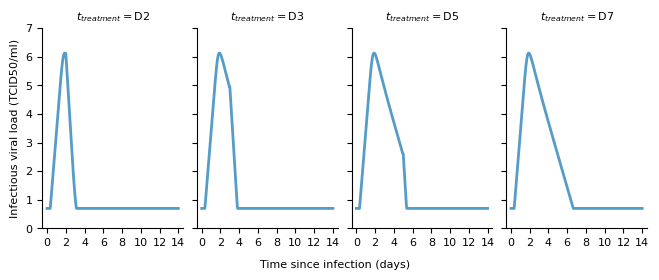

In [9]:
within_host_model_pars = np.load("../data/within_host_pars.npz")['within_host_model_pars']

fig = plt.figure(figsize=(7.8, 10.4 * 0.25))
gs = gridspec.GridSpec(nrows=1, ncols=4, wspace=0.1)

bw, bm, l, r, d, k, q, a, pw, cw, pmb, cmb, Vw0, mub, eb, eo = within_host_model_pars 
print (within_host_model_pars)

rate_pars = np.asarray([bw, bm, l, r, d, k, q, a, pw, cw])
T0 = 4e8 

for axi, treatment_t in enumerate([2, 3, 5, 7]): 
    ax = fig.add_subplot(gs[axi])

    # get tspan 
    tspan = np.linspace(0., 14., (14*24)+1)

    # two phase (pre-treatment and post-treatment)
    # pre-treatment 
    t0 = tspan[tspan < treatment_t] 
    y0_init = np.asarray([T0, 0., 0., 0., 0., Vw0, 0.])
    s0 = solve_model(rate_pars, pm=0., cm=0., mu=0., e=0., tspan=t0, y_init=y0_init)
    
    # post-treatment 
    t1 = tspan[tspan >= treatment_t] 
    y1_init = s0[-1,:]
    s1 = solve_model(rate_pars, pm=0., cm=0., mu=0., e=eb, tspan=t1, y_init=y1_init)
    # fit viral load to baloxavir treated data 
    s0_Vw = s0[:,-2]
    s1_Vw = s1[:,-2]
    s0_Vw[s0_Vw < 5.] = 5. 
    s1_Vw[s1_Vw < 5.] = 5. 
    V = np.log10(np.concatenate((s0_Vw, s1_Vw)))

    ax.plot(tspan, V, lw=2., c='#2b83ba', alpha=0.8)
    
    
    ax.set_ylim(0., 7.)
    ax.set_xticks(np.arange(0, 15, 2))
    ax.set_xlim(-0.5, 14.5)
    for axis in ['top', 'right']: 
        ax.spines[axis].set_visible(False)
    if axi == 0: 
        ax.set_ylabel('Infectious viral load (TCID50/ml)', fontsize=8)
    else: 
        ax.set_yticklabels([])

    ax.set_title(r"$t_{treatment} = $" + "D%i"%(treatment_t), fontsize=8)
    ax.tick_params(labelsize=8)

fig.text(x = 0.5, y = -0.05, s="Time since infection (days)", ha='center', va='bottom', fontsize=8)
plt.savefig("../manuscript/lancetID_fig_s03.png", dpi=600, bbox_inches='tight')
plt.show()